In [1]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("../")
from Data import Data_eval
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm


import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

2023-05-10 18:58:02.238649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

In [5]:
name_model = "/cerea_raid/users/dumontj/dev/coco2/dl/weights/tur/best_no2"
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Tur/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forTur_2/valid_dataset.nc"

### On extra_valid data

In [10]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_eval_nc,
)

model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_best.h5"
)

In [27]:
no2 = data.ds.no2.values
plume = data.ds.no2_plume.values
scaled_no2 = no2 - plume + 0.5 * plume
data.x.eval[:, :, :, -1] = scaled_no2 + np.random.randn(*scaled_no2.shape) * scaled_no2

In [29]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

197/197 [==============================] - 1s 4ms/step
mae: 3.2864146 2.5939503
mape: 39.33707 29.994656


In [11]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]), np.median(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]), np.median(metrics["mape"]))

197/197 [==============================] - 1s 4ms/step
mae: 2.323162 1.8594122
mape: 27.281223 22.364548


In [8]:
mean_metrics = model_eval.get_inv_mean_loss(data)
print("mae:", np.mean(mean_metrics["mae"]))
print("mape:", np.mean(mean_metrics["mape"]))

mae: 1.6552863
mape: 20.697556


197/197 [==============================] - 1s 4ms/step


<Figure size 1920x1440 with 0 Axes>

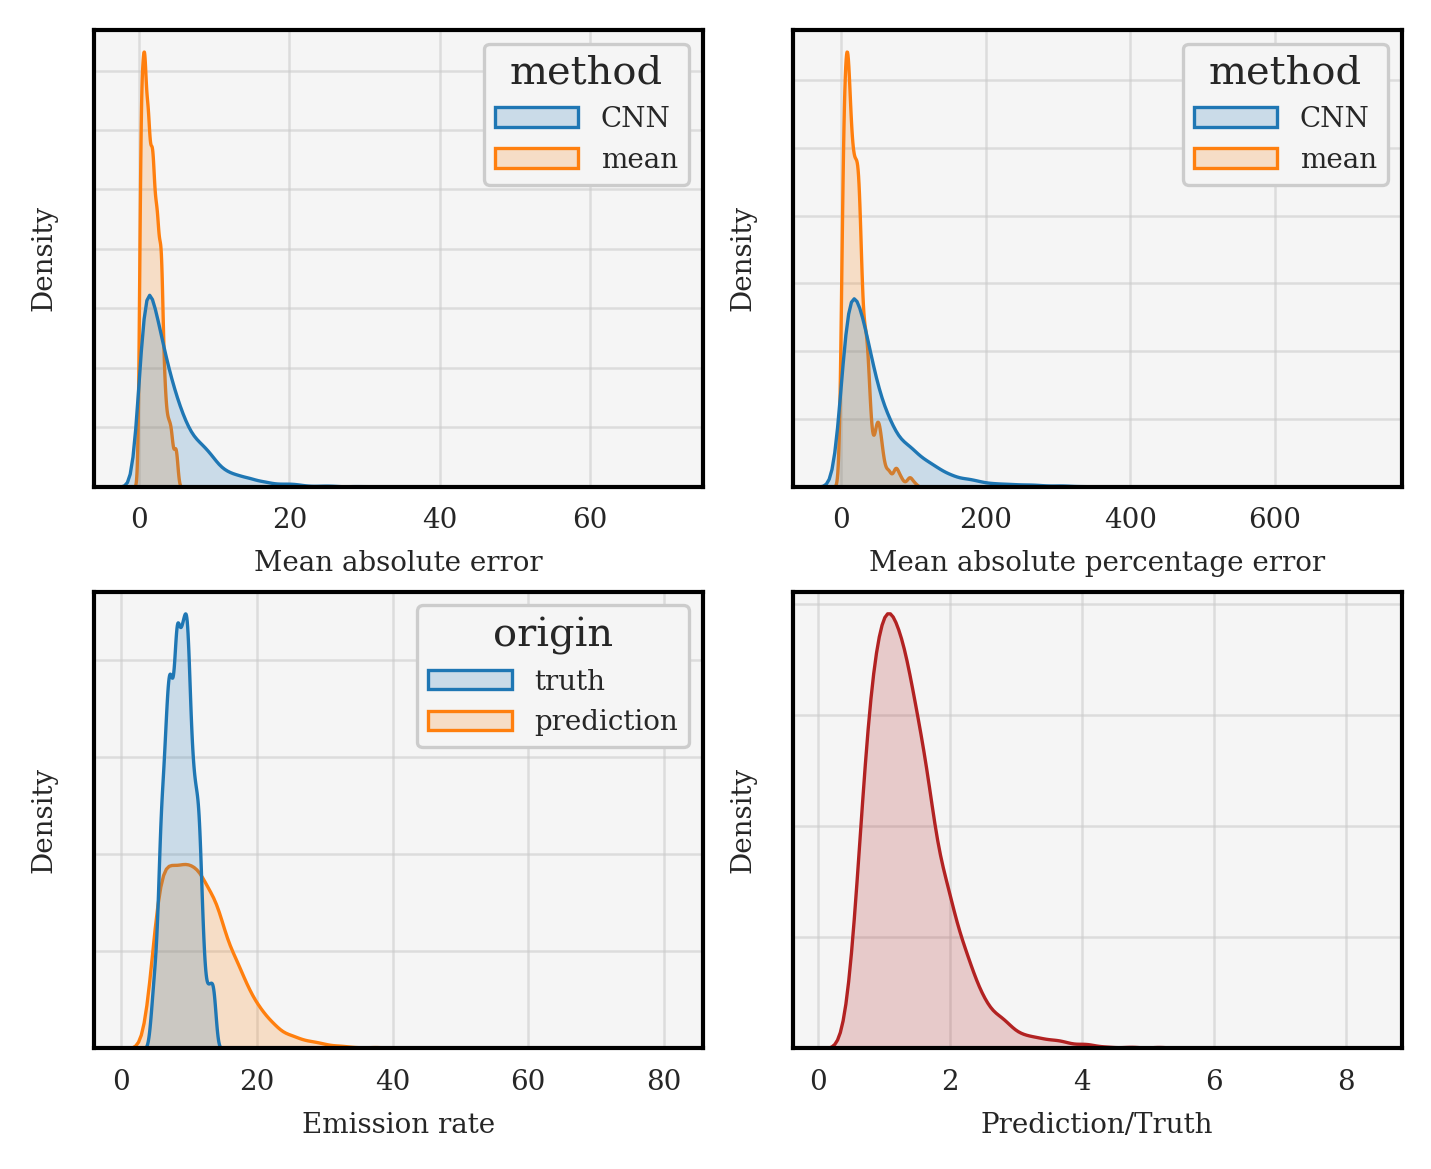

In [9]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: tf.Tensor(3.2855024, shape=(), dtype=float32)
idx 3751
origin: smart_2km_Tur_64
time: 2015-08-01T07:00:00.000000000
emiss: [7.40873  5.488179 4.870472]
nwbce: tf.Tensor(0.40665627, shape=(), dtype=float32)
idx 3306
origin: smart_2km_Tur_64
time: 2015-07-09T18:00:00.000000000
emiss: [8.225724 8.700468 9.016977]
nwbce: tf.Tensor(1.5430431, shape=(), dtype=float32)
idx 2111
origin: smart_2km_Tur_64
time: 2015-04-30T23:00:00.000000000
emiss: [8.066043 9.257641 9.349636]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

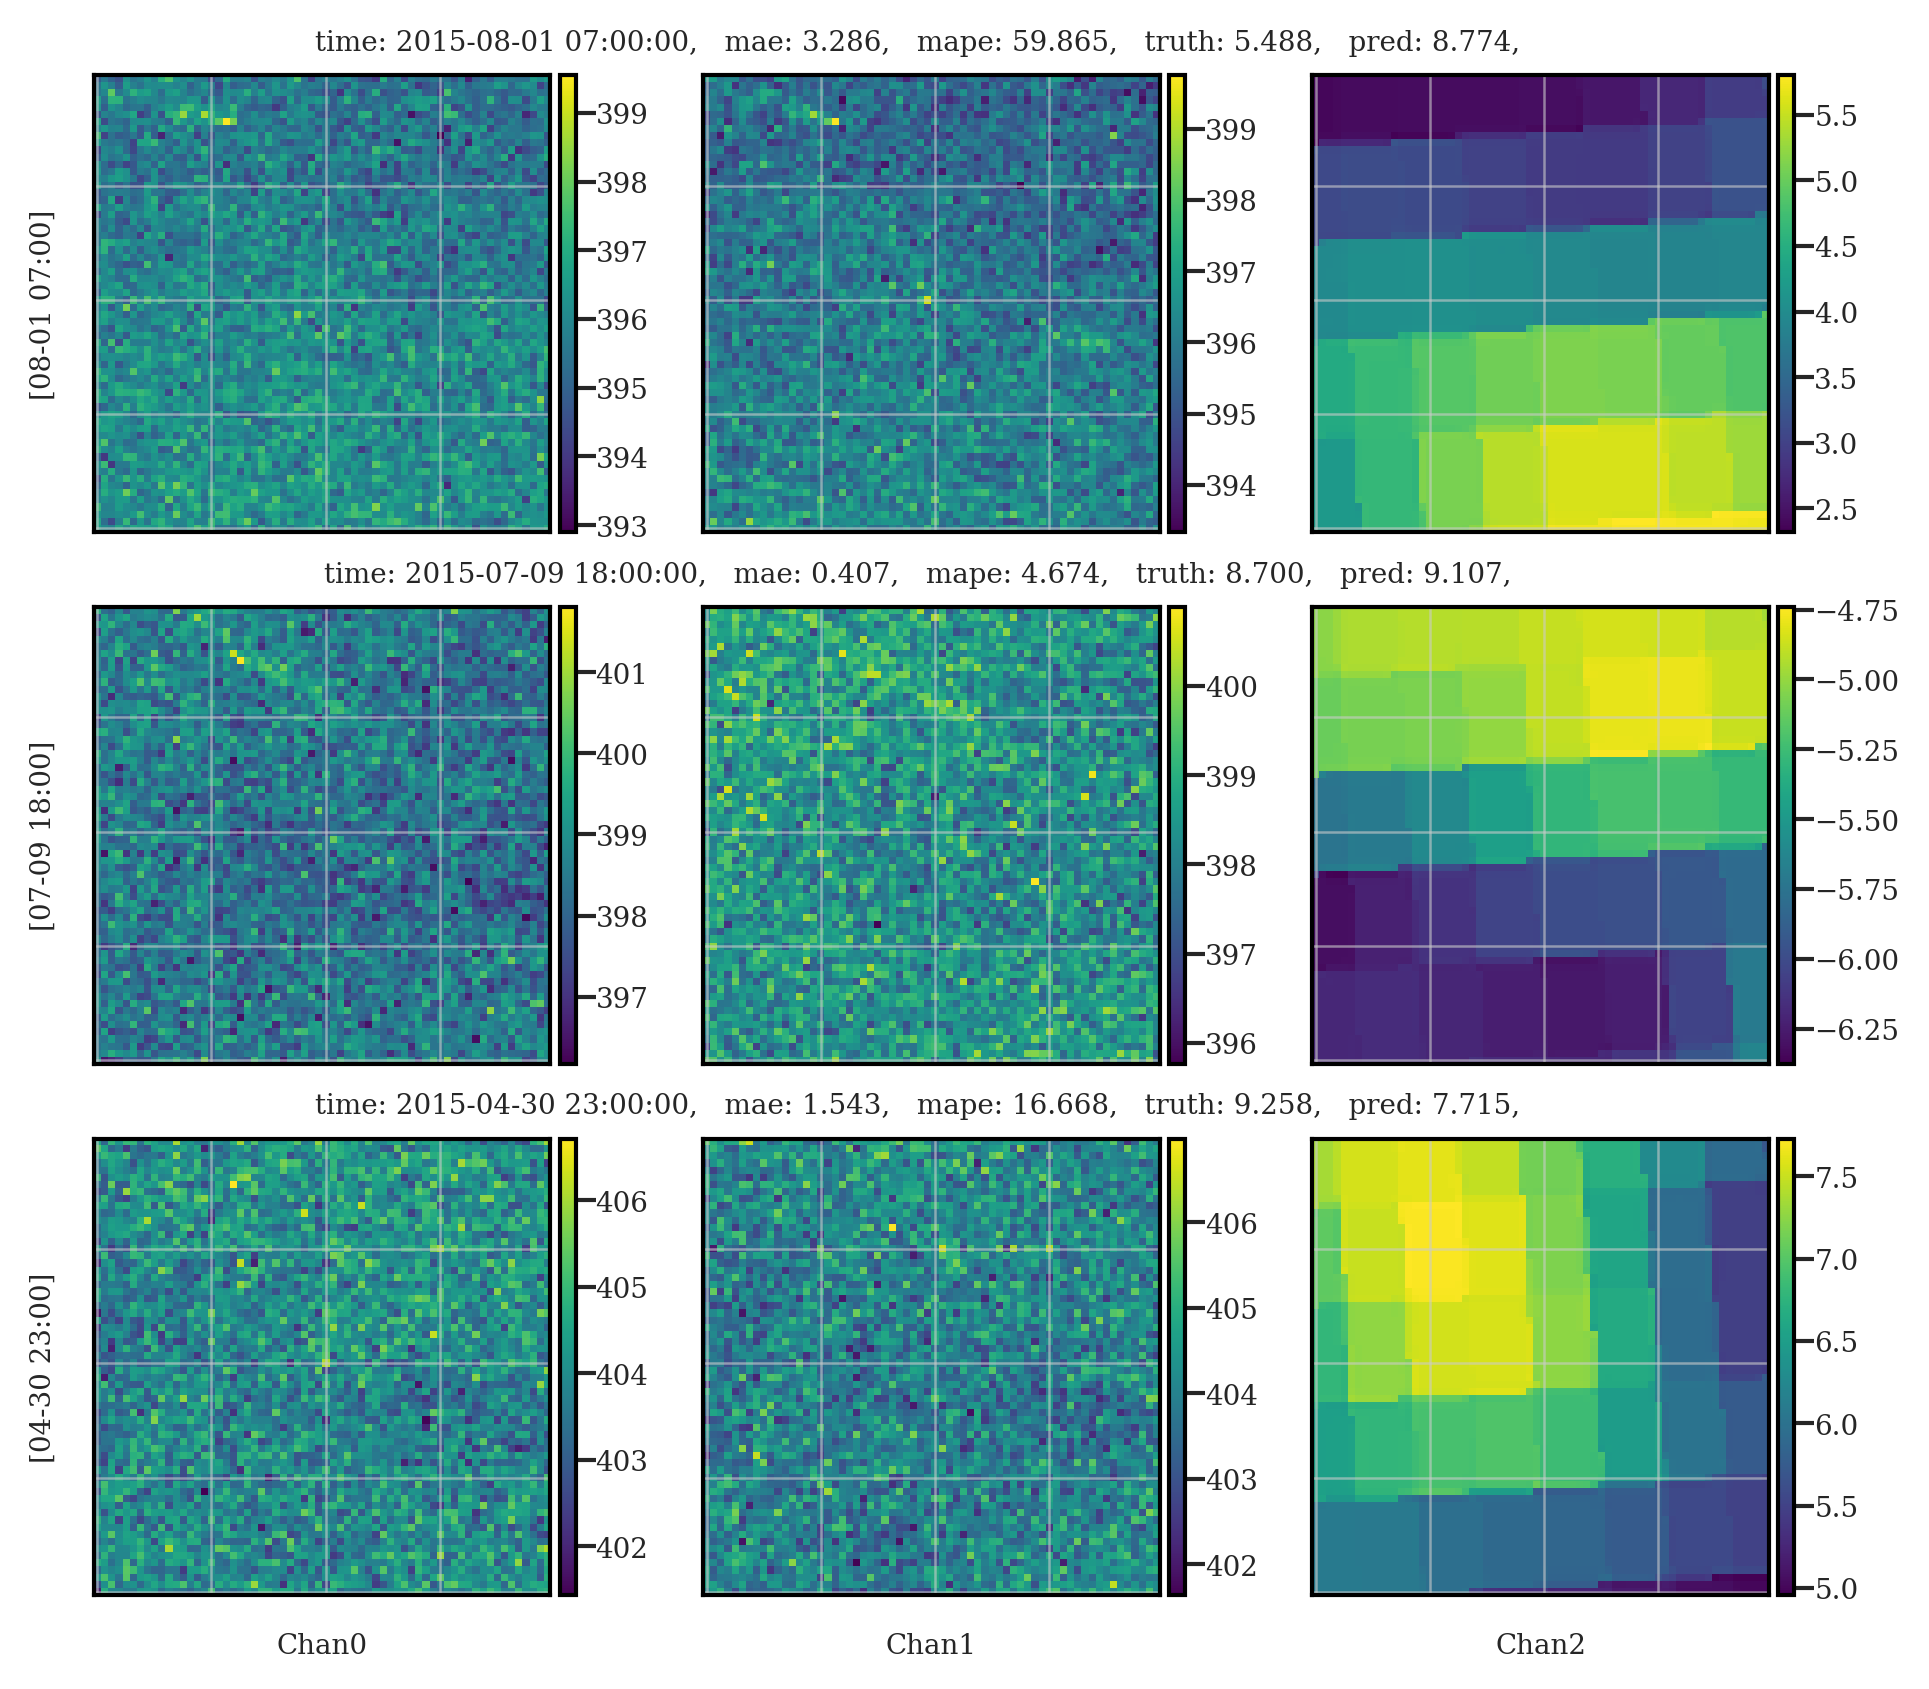

In [10]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)

### On validation dataset

In [9]:
data_val = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_valid_nc,
)

In [10]:
metrics_val = model_eval.get_inv_metrics_model_on_data(model, data_val)
print("mae:", np.mean(metrics_val["mae"]))
print("mape:", np.mean(metrics_val["mape"]))

144/144 [==============================] - 1s 4ms/step
mae: 3.1444042
mape: 24.393858


144/144 [==============================] - 1s 5ms/step


<Figure size 1920x1440 with 0 Axes>

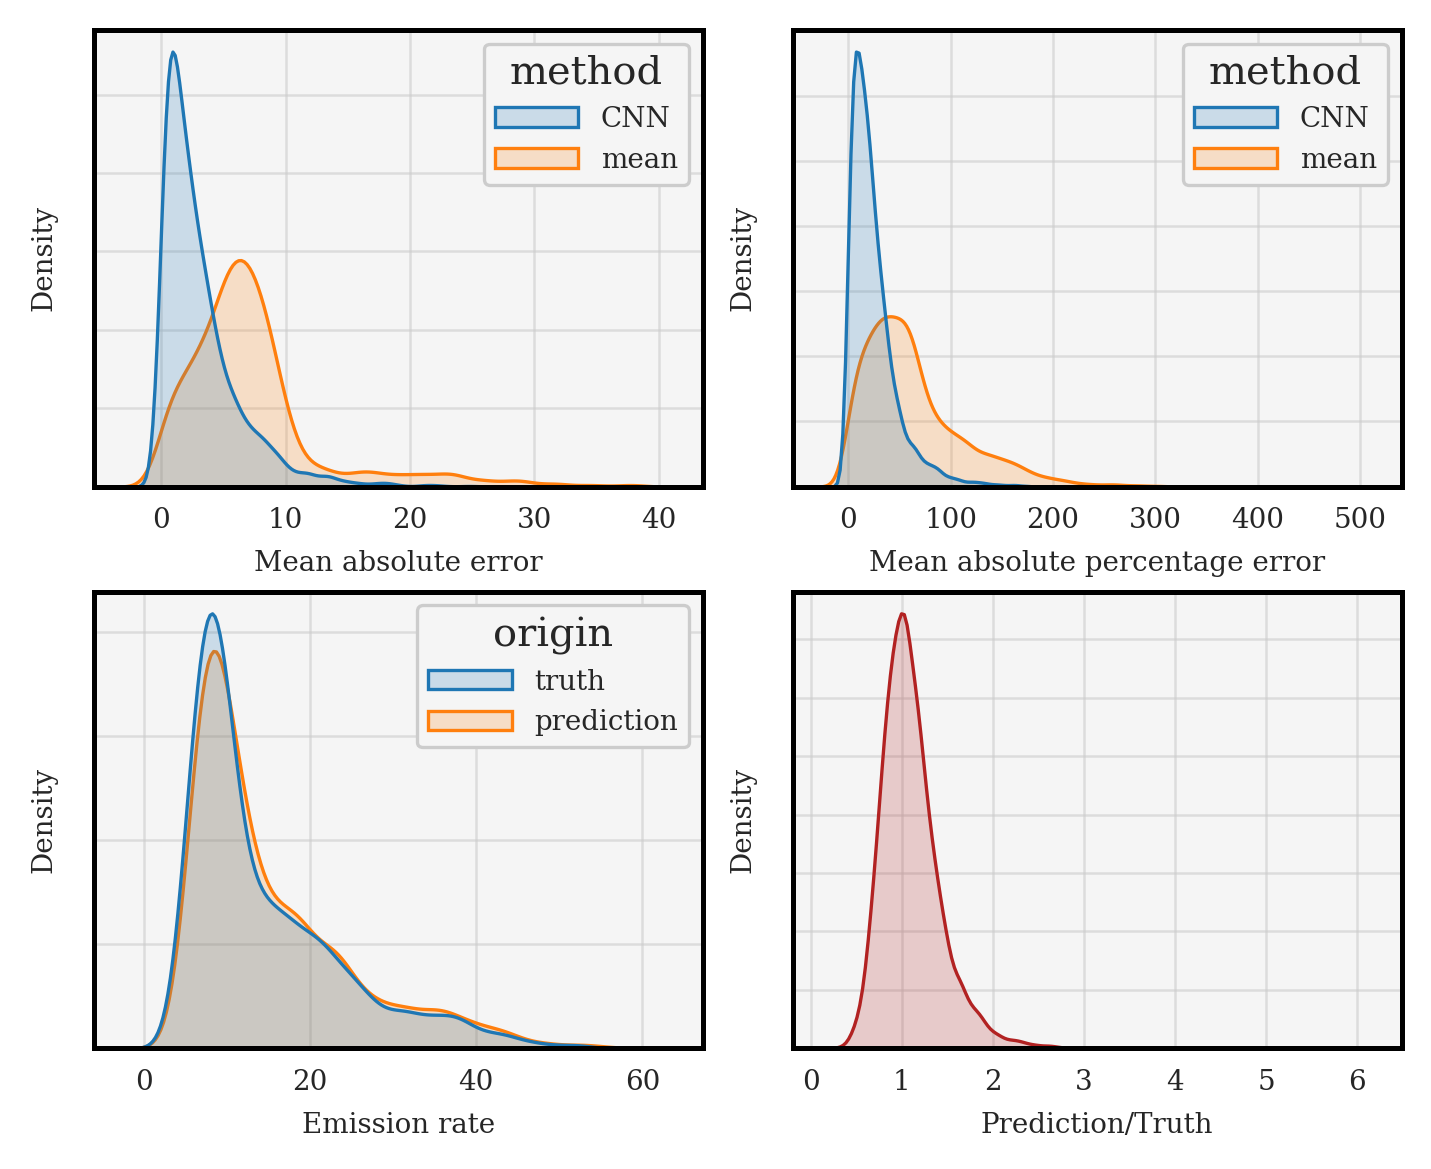

In [11]:
model_eval.get_summary_histo_inversion(model, data_val)

nwbce: tf.Tensor(4.7776527, shape=(), dtype=float32)
idx 3508
origin: smart_2km_Tur_64
time: 2015-02-06T09:00:00.000000000
emiss: [13.59573  12.036     8.915542]
nwbce: tf.Tensor(0.26356316, shape=(), dtype=float32)
idx 4301
origin: smart_2km_Schp_64
time: 2015-06-21T11:00:00.000000000
emiss: [6.905538 6.962628 6.163816]
nwbce: tf.Tensor(0.11393547, shape=(), dtype=float32)
idx 2750
origin: smart_2km_Jan_64
time: 2015-10-07T05:00:00.000000000
emiss: [28.22937 25.05334 25.40612]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

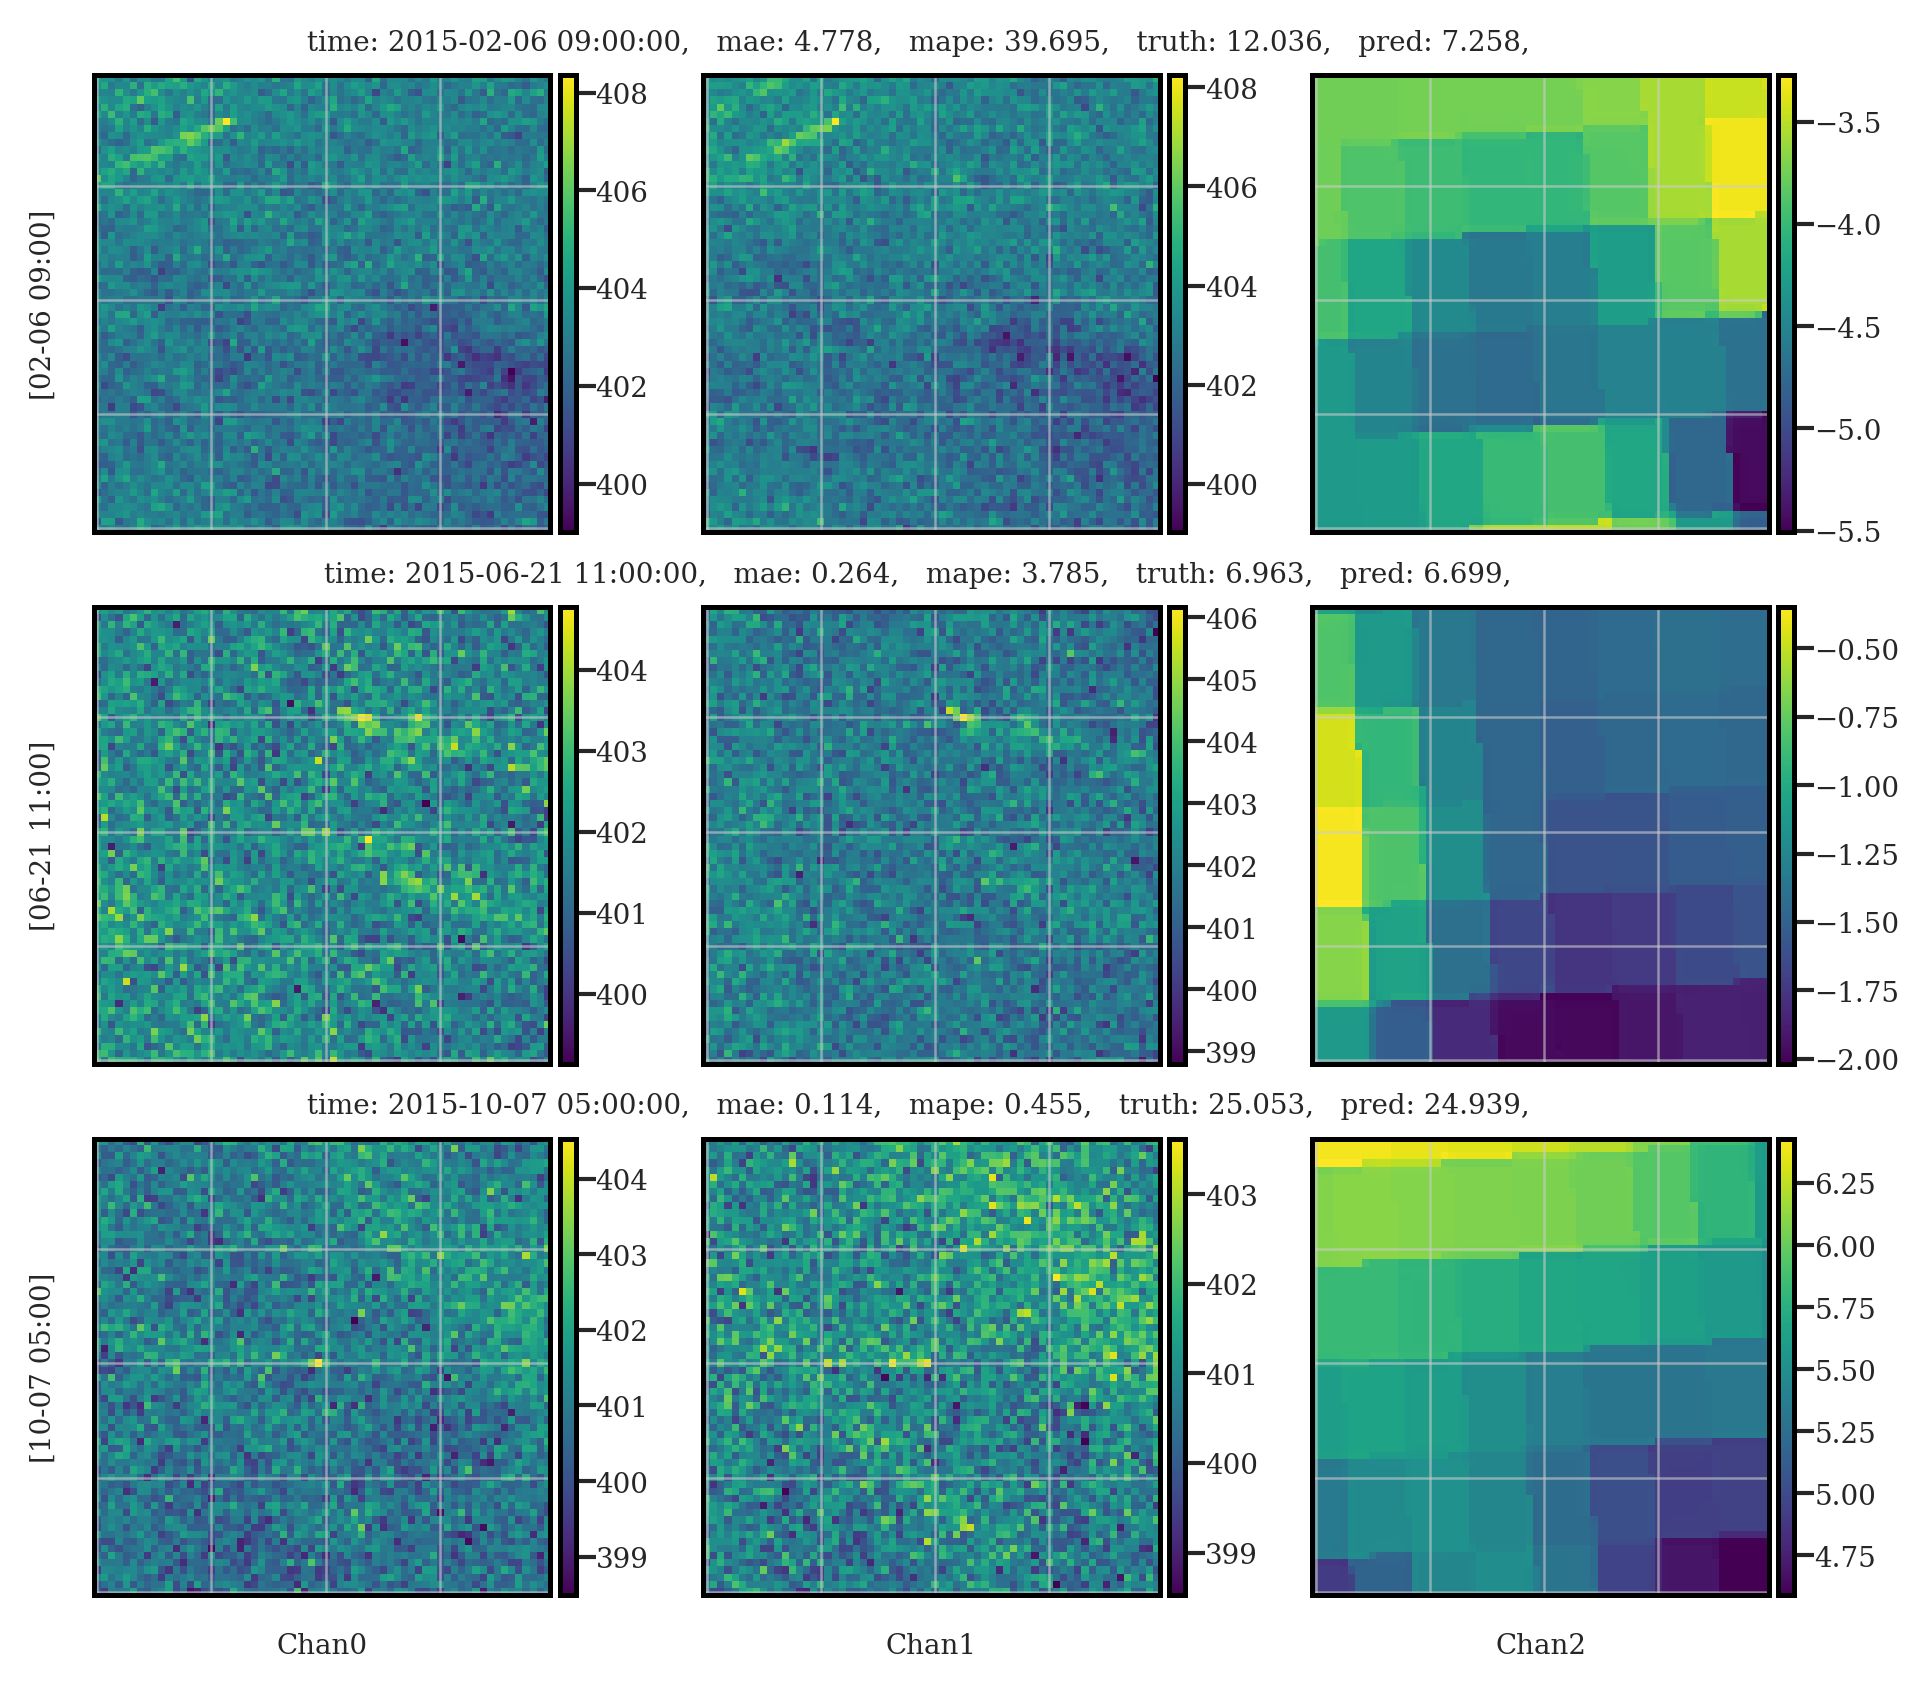

In [12]:
model_eval.plot_inversion_examples(
    data_val, metrics_val["mae"], metrics_val["mape"], model
)

### Gradient based method

In [24]:
plume = np.expand_dims(data.ds.plume.values, -1)
back = np.expand_dims(data.ds.xco2_back.values, -1)

tf.Tensor(5.260096303770341, shape=(), dtype=float64)


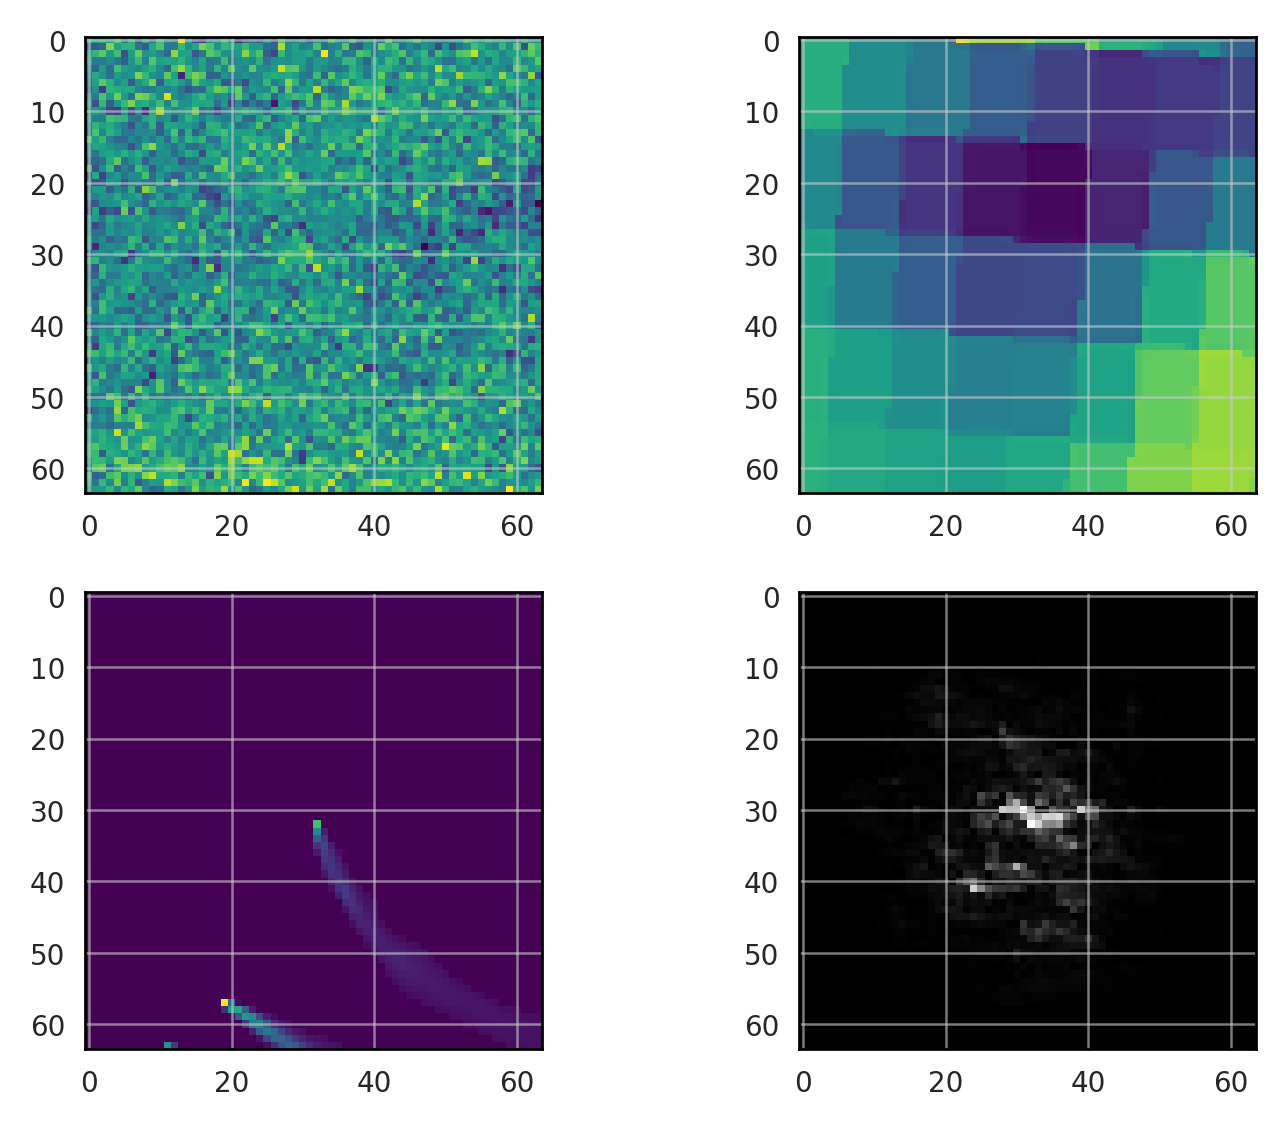

In [25]:
idx = np.random.choice(data.ds.attrs["N_img"])
x = data.x.eval[idx : idx + 1]
y = data.y.eval[idx : idx + 1]
x = tf.cast(x, tf.float32)  # Convert to float32


# Define loss function
loss_function = tf.keras.losses.MeanAbsolutePercentageError()
print(loss_function(model(x), y))

# Define gradient function
@tf.function
def get_gradients(input_image, model, loss_function, target):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = loss_function(predictions, target)
    gradients = tape.gradient(loss, input_image)
    return gradients


# Compute gradient-based feature importance
gradients = get_gradients(x, model, loss_function, y)
importance = tf.reduce_max(tf.abs(gradients), axis=-1)

axs = mympf.set_figure_axs(2, 2)
axs[0].imshow(np.squeeze(data.x.eval[idx, :, :, 0]))
axs[1].imshow(np.squeeze(data.x.eval[idx, :, :, 1]))
axs[2].imshow(np.squeeze(plume[idx, :, :, 0]))
axs[3].imshow(np.squeeze(importance.numpy()), cmap="gray")
plt.show()

In [26]:
baseline_tensor = tf.zeros_like(x)

In [27]:
def integrated_gradients(model, img_tensor, baseline_tensor, num_steps=100):
    # Define the path from baseline to input as a straight line
    alphas = tf.linspace(start=0.0, stop=1.0, num=num_steps + 1)

    # Compute the gradients of the model's output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
    grads = tape.gradient(predictions, img_tensor)

    # Compute the gradient at each point along the path
    interpolated_inputs = [
        (baseline_tensor + alpha * (img_tensor - baseline_tensor)) for alpha in alphas
    ]
    interpolated_inputs = tf.stack(interpolated_inputs)
    interpolated_inputs = tf.reshape(
        interpolated_inputs, [-1] + list(img_tensor.shape[1:])
    )
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        interpolated_predictions = model(interpolated_inputs)
    interpolated_grads = tape.gradient(interpolated_predictions, interpolated_inputs)

    # Approximate the integral using the trapezoidal rule
    avg_grads = tf.reduce_mean(interpolated_grads, axis=0)
    integrated_grads = tf.reduce_sum(avg_grads * (img_tensor - baseline_tensor), axis=0)
    return integrated_grads

In [91]:
# 299, 460, 5784, 5851, 6078, 1495

In [151]:
idx = np.random.choice(data.ds.attrs["N_img"])
print(idx)
alt_idx = np.random.choice(data.ds.attrs["N_img"])
x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
y = data.y.eval[idx : idx + 1]
baseline_tensor = tf.cast(back[alt_idx : alt_idx + 1], tf.float32)
baseline_tensor = tf.zeros_like(x)

integ_grad = integrated_gradients(model, x, baseline_tensor)

1857


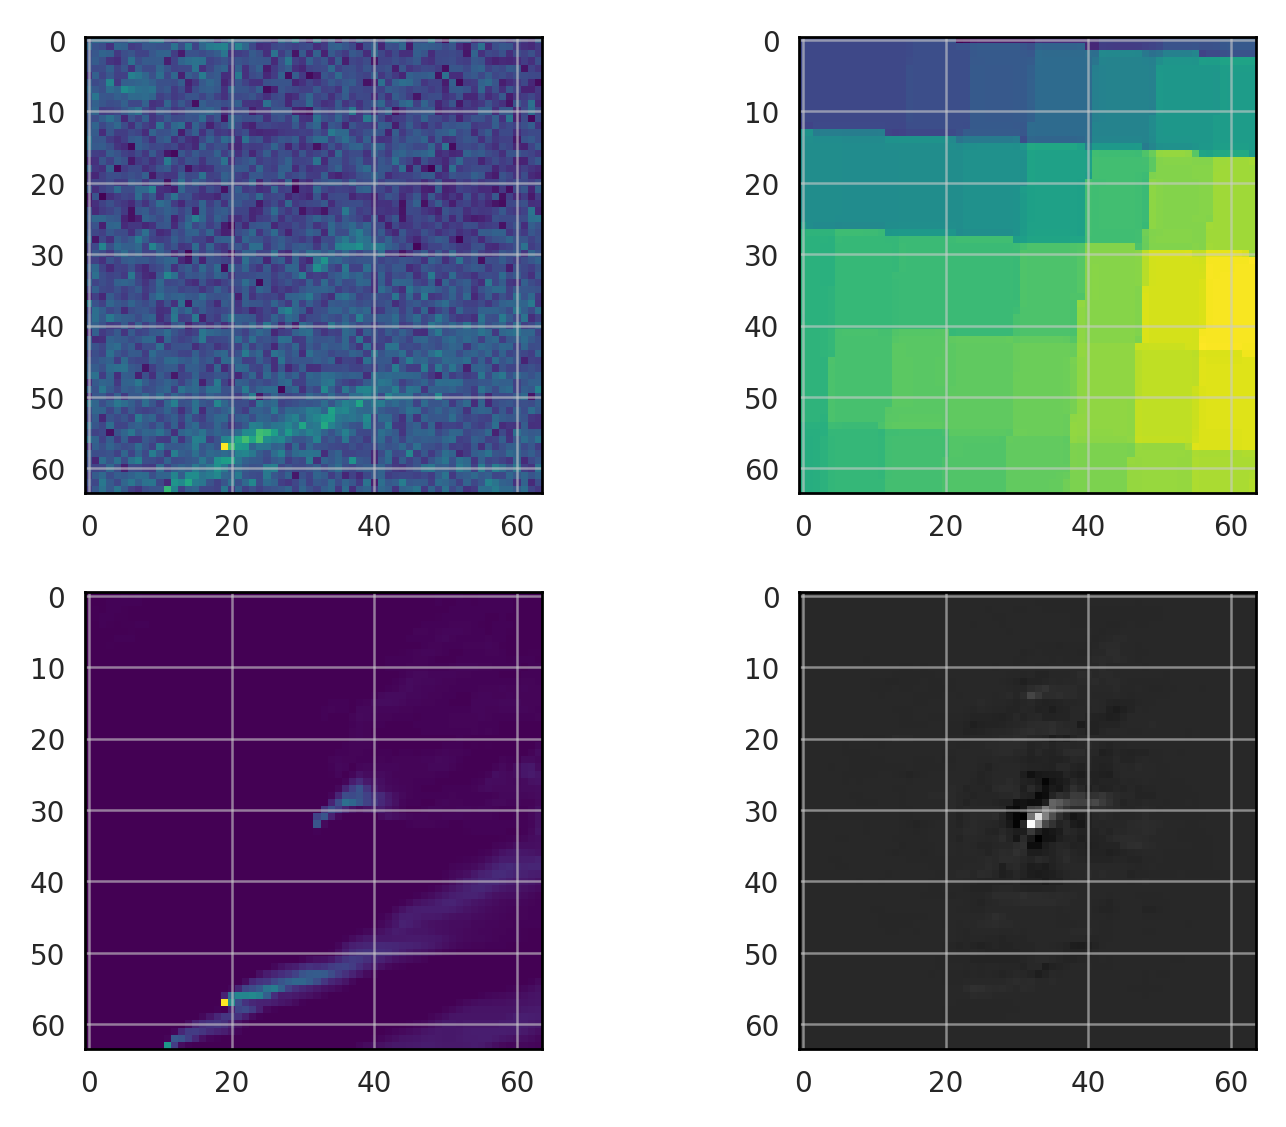

0.21954909140360782
5.134076


In [152]:
axs = mympf.set_figure_axs(2, 2)
axs[0].imshow(np.squeeze(data.x.eval[idx, :, :, 0]))
axs[1].imshow(np.squeeze(data.x.eval[idx, :, :, 1]))
axs[2].imshow(np.squeeze(plume[idx, :, :, 0]))
axs[3].imshow(np.squeeze(integ_grad.numpy()[:, :, 0]), cmap="gray")
plt.show()
print(
    np.corrcoef(
        plume[idx, :, :, 0].flatten(), 
        np.squeeze(integ_grad.numpy()[:, :, 0]).flatten()
    )[0,1]
)
print((metrics["mape"][idx] / np.median(metrics["mape"])).numpy())